In [177]:
# Install required external library
!pip install -q category_encoders

# Core libraries
import os
import io
import warnings
warnings.filterwarnings('ignore')

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.impute import SimpleImputer

# Encoding
import category_encoders as ce

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Model tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, RocCurveDisplay
)

sns.set(style='whitegrid')

In [178]:
df = pd.read_csv("/content/paddydataset.csv"); print(df.shape); df.head()


(2789, 45)


,Hectares,Agriblock,Variety,Soil Types,Seedrate(in Kg),LP_Mainfield(in Tonnes),Nursery,Nursery area (Cents),LP_nurseryarea(in Tonnes),DAP_20days,...,Wind Direction_D1_D30,Wind Direction_D31_D60,Wind Direction_D61_D90,Wind Direction_D91_D120,Relative Humidity_D1_D30,Relative Humidity_D31_D60,Relative Humidity_D61_D90,Relative Humidity_D91_D120,Trash(in bundles),Paddy yield(in Kg)
0,6,Cuddalore,CO_43,alluvial,150,75.0,dry,120,6,240,...,SW,W,NNW,WSW,72.0,78,88,85,540,35028
1,6,Kurinjipadi,ponmani,clay,150,75.0,wet,120,6,240,...,NW,S,SE,SSE,64.6,85,84,87,600,35412
2,6,Panruti,delux ponni,alluvial,150,75.0,dry,120,6,240,...,ENE,NE,NNE,W,85.0,96,84,79,600,36300
3,6,Kallakurichi,CO_43,clay,150,75.0,wet,120,6,240,...,W,WNW,SE,S,88.5,95,81,84,540,35016
4,6,Sankarapuram,ponmani,alluvial,150,75.0,dry,120,6,240,...,SSE,W,SW,NW,72.7,91,83,81,600,34044


# Data cleaning and Preprocessing

In [179]:
# Some datasets contain strange column names; normalize column names:
df.columns = [c.strip().replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace(".", "_") for c in df.columns]
# Detection of the target attribute (Paddy Yield) based on keyword matching in column names
possible_targets = [c for c in df.columns if 'paddy' in c.lower() and ('yield' in c.lower() or 'kg' in c.lower())]
if len(possible_targets) == 0:
    raise SystemExit("Could not find 'Paddy yield' column automatically. Please ensure dataset has a yield column.")
target_col = possible_targets[0]
print("Target column:", target_col)

Target column: Paddy_yieldin_Kg


,0


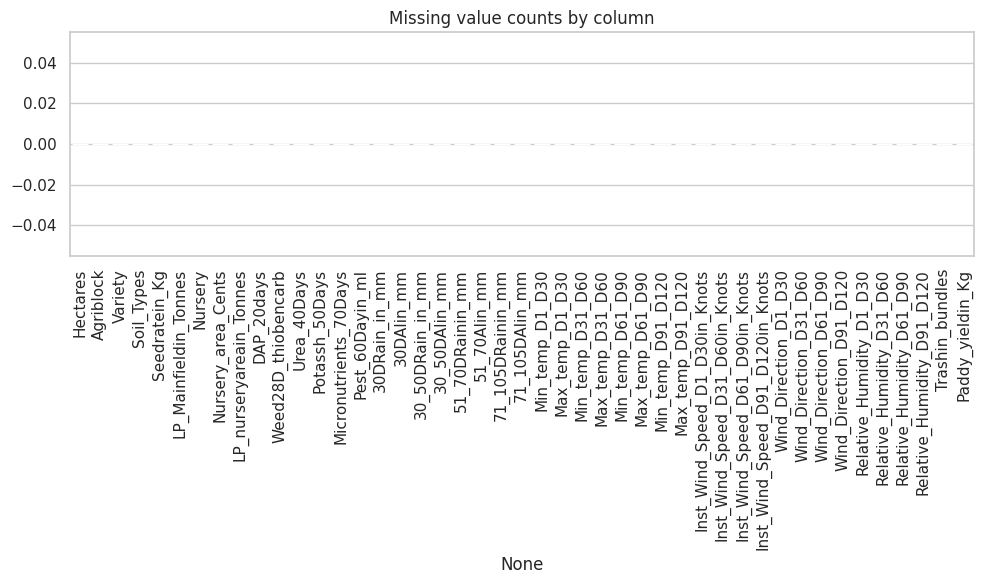

In [180]:
# Missing values check & plot (before handling)
missing_before = df.isnull().sum()
display(missing_before[missing_before > 0])
plt.figure(figsize=(10,6))
sns.barplot(x=missing_before.index, y=missing_before.values)
plt.xticks(rotation=90)
plt.title("Missing value counts by column")
plt.tight_layout()
plt.show()


In [181]:
# Function to count outliers
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((series < lower) | (series > upper)).sum()
    return outliers
# Outliers BEFORE handling
outlier_summary_before = pd.DataFrame({
    "Column": num_cols,
    "Outliers_Before": [count_outliers(df[col]) for col in num_cols]
})

print("Outlier Summary (Before IQR Capping):")
display(outlier_summary_before)

Outlier Summary (Before IQR Capping):


,Column,Outliers_Before
0,Hectares,0
1,Seedratein_Kg,0
2,LP_Mainfieldin_Tonnes,0
3,Nursery_area_Cents,0
4,LP_nurseryareain_Tonnes,0
5,DAP_20days,0
6,Weed28D_thiobencarb,0
7,Urea_40Days,0
8,Potassh_50Days,0
9,Micronutrients_70Days,0


In [182]:
# Perform IQR Capping
def cap_iqr(df_in, col):
    Q1 = df_in[col].quantile(0.25)
    Q3 = df_in[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_in[col] = np.where(df_in[col] < lower, lower, df_in[col])
    df_in[col] = np.where(df_in[col] > upper, upper, df_in[col])
    return df_in

df_capped = df.copy()
for col in num_cols:
    df_capped = cap_iqr(df_capped, col)

# Outliers AFTER handling
outlier_summary_after = pd.DataFrame({
    "Column": num_cols,
    "Outliers_After": [count_outliers(df_capped[col]) for col in num_cols]
})

print("Outlier Summary (After IQR Capping):")
display(outlier_summary_after)

Outlier Summary (After IQR Capping):


,Column,Outliers_After
0,Hectares,0
1,Seedratein_Kg,0
2,LP_Mainfieldin_Tonnes,0
3,Nursery_area_Cents,0
4,LP_nurseryareain_Tonnes,0
5,DAP_20days,0
6,Weed28D_thiobencarb,0
7,Urea_40Days,0
8,Potassh_50Days,0
9,Micronutrients_70Days,0


In [183]:
# Target conversion: Continuous 3-class (Low / Medium / High)
if pd.api.types.is_numeric_dtype(df[target_col]):
    df['yield_class'] = pd.qcut(df[target_col], q=3, labels=['Low', 'Medium', 'High'])
    print("Converted continuous yield into classes with distribution:")
    display(df['yield_class'].value_counts())
else:
    df['yield_class'] = df[target_col].astype(str)

Converted continuous yield into classes with distribution:


,count
yield_class,
Low,950
High,923
Medium,916


In [184]:
# Encoding + scaling
# Prepare X and y
df_capped['yield_class'] = df['yield_class']
X = df_capped.drop(columns=[target_col, 'yield_class'])
y = df_capped['yield_class']

# Identify categorical and numeric columns from X
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Simple one-hot encoding for all categorical columns
if len(cat_cols) > 0:
    X_cat = pd.get_dummies(X[cat_cols], drop_first=True)
else:
    X_cat = pd.DataFrame(index=X.index)

# Numeric features
X_num = X[num_cols].copy()

# Combine numeric and encoded categorical features
X_processed = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)

# Scale only the numeric columns
scaler = StandardScaler()
if len(num_cols) > 0:
    X_processed[num_cols] = scaler.fit_transform(X_processed[num_cols])
display(X_processed.head())


,Hectares,Seedratein_Kg,LP_Mainfieldin_Tonnes,Nursery_area_Cents,LP_nurseryareain_Tonnes,DAP_20days,Weed28D_thiobencarb,Urea_40Days,Potassh_50Days,Micronutrients_70Days,...,Wind_Direction_D31_D60_WNW,Wind_Direction_D61_D90_NNE,Wind_Direction_D61_D90_NNW,Wind_Direction_D61_D90_SE,Wind_Direction_D61_D90_SW,Wind_Direction_D91_D120_NW,Wind_Direction_D91_D120_S,Wind_Direction_D91_D120_SSE,Wind_Direction_D91_D120_W,Wind_Direction_D91_D120_WSW
0,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,...,False,False,True,False,False,False,False,False,False,True
1,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,...,False,False,False,True,False,False,False,True,False,False
2,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,...,False,True,False,False,False,False,False,False,True,False
3,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,...,True,False,False,True,False,False,True,False,False,False
4,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,1.587832,...,False,False,False,False,True,True,False,False,False,False


# Exploratory Data Analysis (plots)

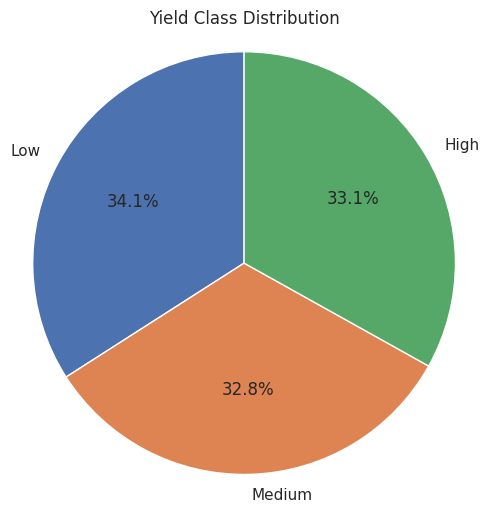

In [185]:
# Pie Chart: distribution of yield_class
plt.figure(figsize=(6,6))
y_counts = y.value_counts().reindex(['Low','Medium','High']).fillna(0)
plt.pie(y_counts, labels=y_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Yield Class Distribution")
plt.axis('equal')
plt.show()

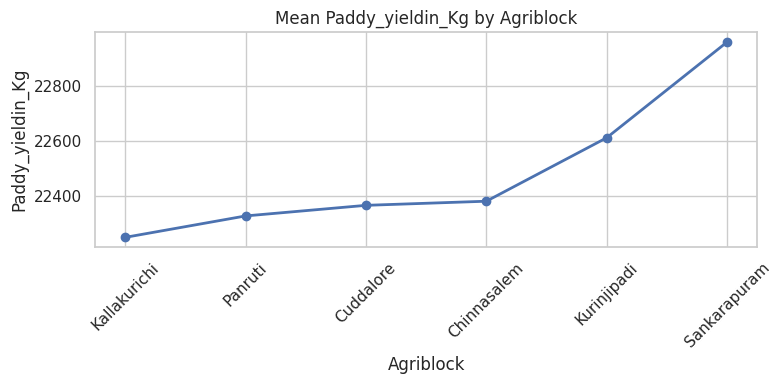

In [186]:
# Line Chart: mean continuous yield by Agribloc
plt.figure(figsize=(8,4))
if 'Agriblock' in df.columns:
    if target_col in df.columns and pd.api.types.is_numeric_dtype(df[target_col]):
        mean_by_block = df.groupby('Agriblock')[target_col].mean().sort_values()
        mean_by_block.plot(marker='o', linewidth=2)
        plt.ylabel(target_col)
        plt.title("Mean {} by Agriblock".format(target_col))
        plt.xlabel("Agriblock")
        plt.xticks(rotation=45)
    else:
        df['Agriblock'].value_counts().sort_index().plot(kind='line', marker='o')
        plt.ylabel("Count")
        plt.title("Count per Agriblock (line)")
        plt.xlabel("Agriblock")
        plt.xticks(rotation=45)
else:
    numeric_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols_all) > 0:
        col0 = numeric_cols_all[0]
        df[col0].reset_index(drop=True).rolling(window=5, min_periods=1).mean().plot()
        plt.ylabel(col0)
        plt.title(f"Rolling-mean trend of {col0} (line)")
    else:
        plt.text(0.5, 0.5, "No suitable column for line plot", ha='center')
plt.tight_layout()
plt.show()

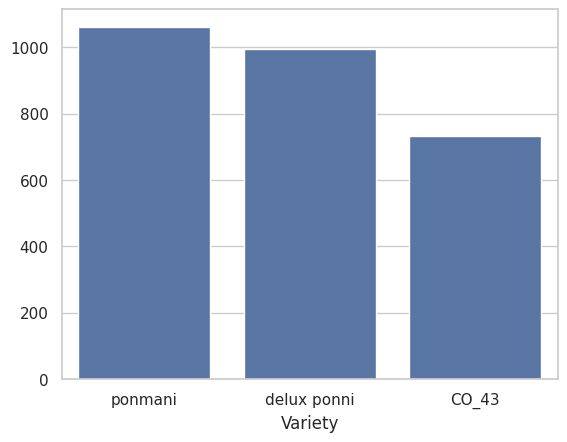

In [187]:
# Bar Chart: counts per Variety
if 'Variety' in df.columns:
    vc = df['Variety'].value_counts()
    sns.barplot(x=vc.index, y=vc.values)
else:
    numeric_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols_all) > 0:
        col0 = numeric_cols_all[0]
        df[col0].reset_index(drop=True).rolling(window=5, min_periods=1).mean().plot()


In [188]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)
print("Train/test sizes:", X_train.shape, X_test.shape)

Train/test sizes: (2231, 63) (558, 63)


In [189]:
# Machine Learning Models building and training
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='ovr'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Support Vector Machine": SVC(probability=True, kernel='rbf', random_state=42)
}
print("Training models...\n")
fitted_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(f"{name} trained successfully.")

Training models...

Logistic Regression trained successfully.
K-Nearest Neighbors trained successfully.
Support Vector Machine trained successfully.


In [190]:
# Performances for all models
print("Model Performance Metrics:")
for name, model in fitted_models.items():
    y_pred = model.predict(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec  = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1   = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"\n{name}:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1 Score : {f1:.4f}")

Model Performance Metrics:

Logistic Regression:
  Accuracy : 0.8996
  Precision: 0.9128
  Recall   : 0.8996
  F1 Score : 0.8941

K-Nearest Neighbors:
  Accuracy : 0.8817
  Precision: 0.8820
  Recall   : 0.8817
  F1 Score : 0.8783

Support Vector Machine:
  Accuracy : 0.8925
  Precision: 0.8968
  Recall   : 0.8925
  F1 Score : 0.8883


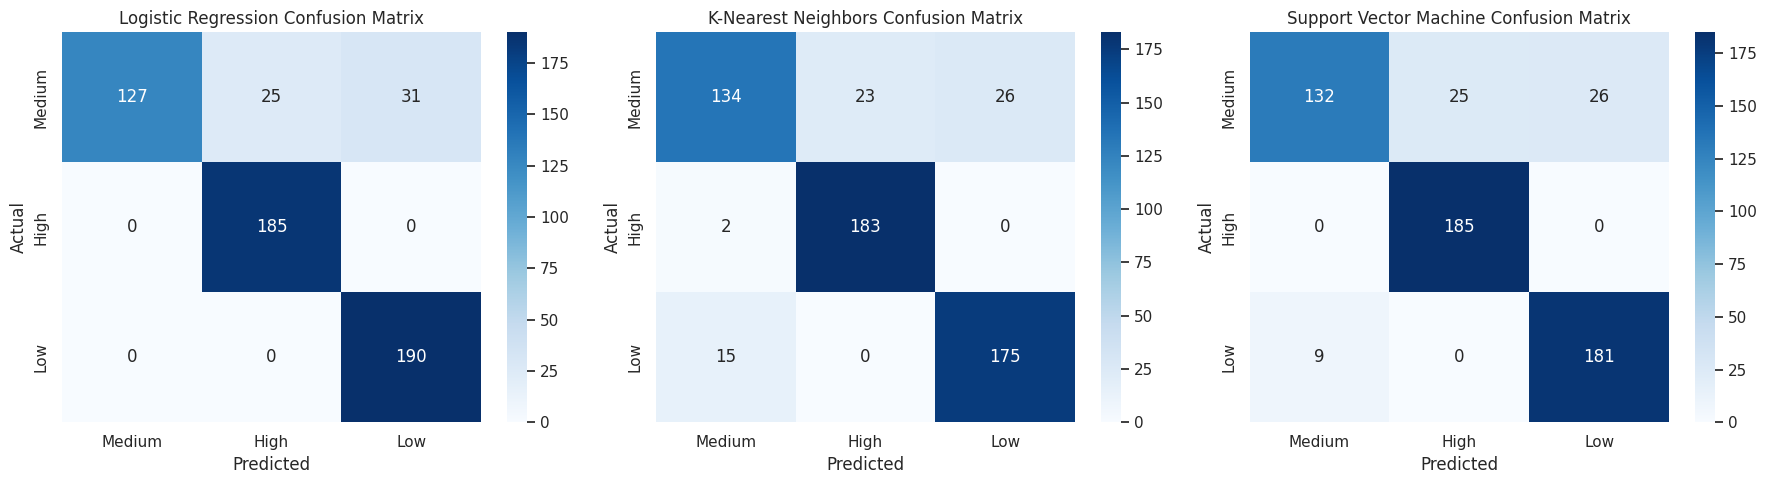

In [191]:
models_to_plot = ["Logistic Regression", "K-Nearest Neighbors", "Support Vector Machine"]
plt.figure(figsize=(18, 5))
for i, model_name in enumerate(models_to_plot, 1):
    model = fitted_models[model_name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=y_test.unique(),
                yticklabels=y_test.unique())
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [192]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def print_metrics(model_name, y_test, y_pred):
    acc  = accuracy_score(y_test,    y_pred)
    prec = precision_score(y_test,   y_pred, average='weighted', zero_division=0)
    rec  = recall_score(y_test,      y_pred, average='weighted', zero_division=0)
    f1   = f1_score(y_test,          y_pred, average='weighted', zero_division=0)
    print(f"\nTuned {model_name} Performance:")
    print(f"{model_name}:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1 Score : {f1:.4f}")

# Logistic Regression
lr_grid = {
    "C": [0.1, 1, 10],
    "solver": ["lbfgs"],
    "class_weight": [None]
}
lr = LogisticRegression(max_iter=2000, multi_class='ovr', random_state=42)
lr_search = GridSearchCV(lr, lr_grid, scoring="accuracy", cv=cv, n_jobs=-1)
lr_search.fit(X_train, y_train)
best_lr = lr_search.best_estimator_
print("\nBest Logistic Regression Params:", lr_search.best_params_)
print_metrics("Logistic Regression", y_test, best_lr.predict(X_test))

# KNN
knn_grid = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform"],
}
knn = KNeighborsClassifier()
knn_search = GridSearchCV(knn, knn_grid, scoring="accuracy", cv=cv, n_jobs=-1)
knn_search.fit(X_train, y_train)
best_knn = knn_search.best_estimator_
print("\nBest KNN Params:", knn_search.best_params_)
print_metrics("K-Nearest Neighbors", y_test, best_knn.predict(X_test))

# SVM
svm_grid = {
    "C": [1, 10],
    "kernel": ["rbf"],
    "gamma": ["scale"]
}
svm = SVC(probability=True, random_state=42)
svm_search = GridSearchCV(svm, svm_grid, scoring="accuracy", cv=cv, n_jobs=-1)
svm_search.fit(X_train, y_train)
best_svm = svm_search.best_estimator_
print("\nBest SVM Params:", svm_search.best_params_)
print_metrics("Support Vector Machine", y_test, best_svm.predict(X_test))



Best Logistic Regression Params: {'C': 0.1, 'class_weight': None, 'solver': 'lbfgs'}

Tuned Logistic Regression Performance:
Logistic Regression:
  Accuracy : 0.8996
  Precision: 0.9128
  Recall   : 0.8996
  F1 Score : 0.8941

Best KNN Params: {'n_neighbors': 7, 'weights': 'uniform'}

Tuned K-Nearest Neighbors Performance:
K-Nearest Neighbors:
  Accuracy : 0.8817
  Precision: 0.8820
  Recall   : 0.8817
  F1 Score : 0.8781

Best SVM Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Tuned Support Vector Machine Performance:
Support Vector Machine:
  Accuracy : 0.8925
  Precision: 0.8968
  Recall   : 0.8925
  F1 Score : 0.8883


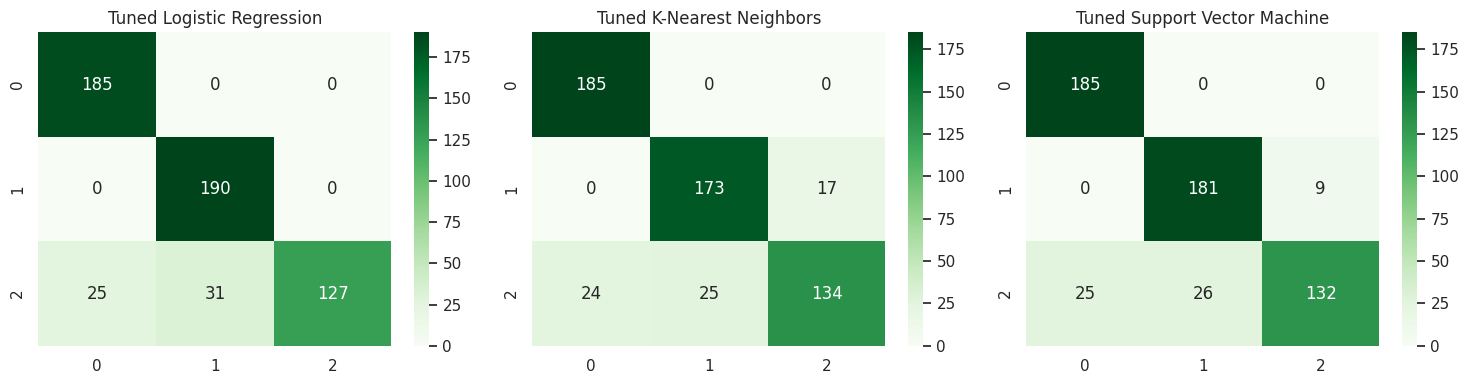

In [196]:
classes = sorted(y_test.unique())

# Predictions
y_lr  = best_lr.predict(X_test)
y_knn = best_knn.predict(X_test)
y_svm = best_svm.predict(X_test)

# Confusion Matrices
cm_lr  = confusion_matrix(y_test, y_lr,  labels=classes)
cm_knn = confusion_matrix(y_test, y_knn, labels=classes)
cm_svm = confusion_matrix(y_test, y_svm, labels=classes)

# Plot
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.heatmap(cm_lr, annot=True, cmap="Greens", fmt='d')
plt.title("Tuned Logistic Regression")
plt.subplot(1,3,2)
sns.heatmap(cm_knn, annot=True, cmap="Greens", fmt='d')
plt.title("Tuned K-Nearest Neighbors")
plt.subplot(1,3,3)
sns.heatmap(cm_svm, annot=True, cmap="Greens", fmt='d')
plt.title("Tuned Support Vector Machine")
plt.tight_layout()
plt.show()


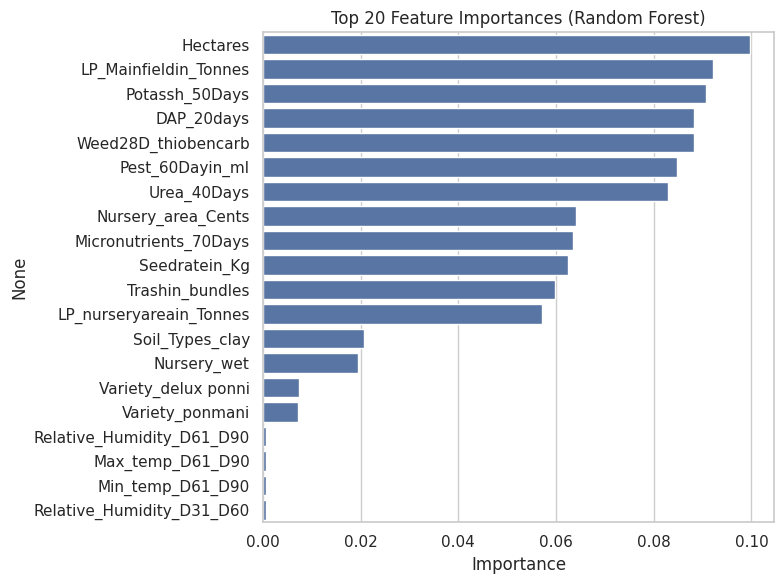

In [195]:
rf_quick = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_quick.fit(X_train, y_train)
# Feature importances
feat_imp = pd.Series(rf_quick.feature_importances_, index=X_processed.columns).sort_values(ascending=False)
top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.head(top_n).values, y=feat_imp.head(top_n).index)
plt.title("Top {} Feature Importances (Random Forest)".format(top_n))
plt.xlabel("Importance")
plt.tight_layout()
plt.show()